# Table of content
1. [Importing relevent libraries](#01)
2. [Loading Dataset](#02)
3. [Distributions](#03)
    - [Age Distribution](#3.1)
    - [Ethnicity Distribution](#3.2)
    - [Gender Distribution](#3.3)
    - [Gender Distribution](#3.3)
    - [Sample Images](#3.4)
4. [Model for Gender Prediction](#04)
    - [Spliting data into train/test](#4.1)
    - [Build and train model](#4.2)
    - [Evaluating training history](#4.3)
5. [Model for Ethnicity Prediction](#05)
    - [Spliting data into train/test](#5.1)
    - [Build and train model](#5.2)
    - [Evaluating training history](#5.3)
6. [Model for Age Prediction](#06)
    - [Spliting data into train/test](#6.1)
    - [Build and train model](#6.2)
    - [Evaluating training history](#6.3)

## Importing relevent libraries <a id="01"></a>

In [32]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split

## Loading Dataset <a id="02"></a>

In [52]:
# Đọc nhãn từ CSV và chuẩn bị cho việc load ảnh trực tiếp
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


csv_file = 'age_gender_labels_only_FINAL_CLEANED.csv'
image_dir = 'data'

jpg_count = len([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
print(f" Số lượng ảnh .jpg: {jpg_count}")

# Đọc nhãn từ CSV
df_labels = pd.read_csv(csv_file)
print(f" Có {len(df_labels):,} dòng")
print(f" Các cột: {list(df_labels.columns)}")

# Kiểm tra ảnh có tồn tại không
valid_data = []
missing_count = 0

for idx, row in df_labels.iterrows():
    img_path = os.path.join(image_dir, row['img_name'])
    if os.path.exists(img_path):
        valid_data.append({
            'filename': row['img_name'],
            'age': row['age'],
            'gender': row['gender'],
            'ethnicity': row['ethnicity'],
            'filepath': img_path
        })

# Tạo DataFrame với data hợp lệ
data = pd.DataFrame(valid_data)
print(f" Tìm thấy {len(data)} ảnh hợp lệ")

# Thống kê
print(f" Tổng samples: {len(data)}")
print(f" Age range: {data['age'].min()} - {data['age'].max()}")
print(f" Gender distribution:")
print(f"   - Male (0): {(data['gender']==0).sum()}")
print(f"   - Female (1): {(data['gender']==1).sum()}")
print(f" Ethnicity distribution:")
for eth in sorted(data['ethnicity'].unique()):
    count = (data['ethnicity']==eth).sum()
    print(f"   - Ethnicity {eth}: {count}")

data.head()


 Số lượng ảnh .jpg: 10137
 Có 9,707 dòng
 Các cột: ['age', 'ethnicity', 'gender', 'img_name']
 Tìm thấy 9707 ảnh hợp lệ
 Tổng samples: 9707
 Age range: 1 - 110
 Gender distribution:
   - Male (0): 4363
   - Female (1): 5344
 Ethnicity distribution:
   - Ethnicity 0: 5217
   - Ethnicity 1: 404
   - Ethnicity 2: 1548
   - Ethnicity 3: 1437
   - Ethnicity 4: 1101


,filename,age,gender,ethnicity,filepath
0,1_0_2_20161219203650636.jpg,1,0,2,data\1_0_2_20161219203650636.jpg
1,1_0_2_20161219222752047.jpg,1,0,2,data\1_0_2_20161219222752047.jpg
2,1_0_2_20161219222832191.jpg,1,0,2,data\1_0_2_20161219222832191.jpg
3,1_0_2_20161220144911423.jpg,1,0,2,data\1_0_2_20161220144911423.jpg
4,1_0_2_20161220144914327.jpg,1,0,2,data\1_0_2_20161220144914327.jpg


🔧 Đang tạo Data Generators...
📊 Train set: 7765 samples
📊 Test set: 1942 samples
✅ Data Generators đã được tạo!
📊 Train generator: 243 batches
📊 Test generator: 61 batches

🖼️ Hiển thị sample images từ generator:


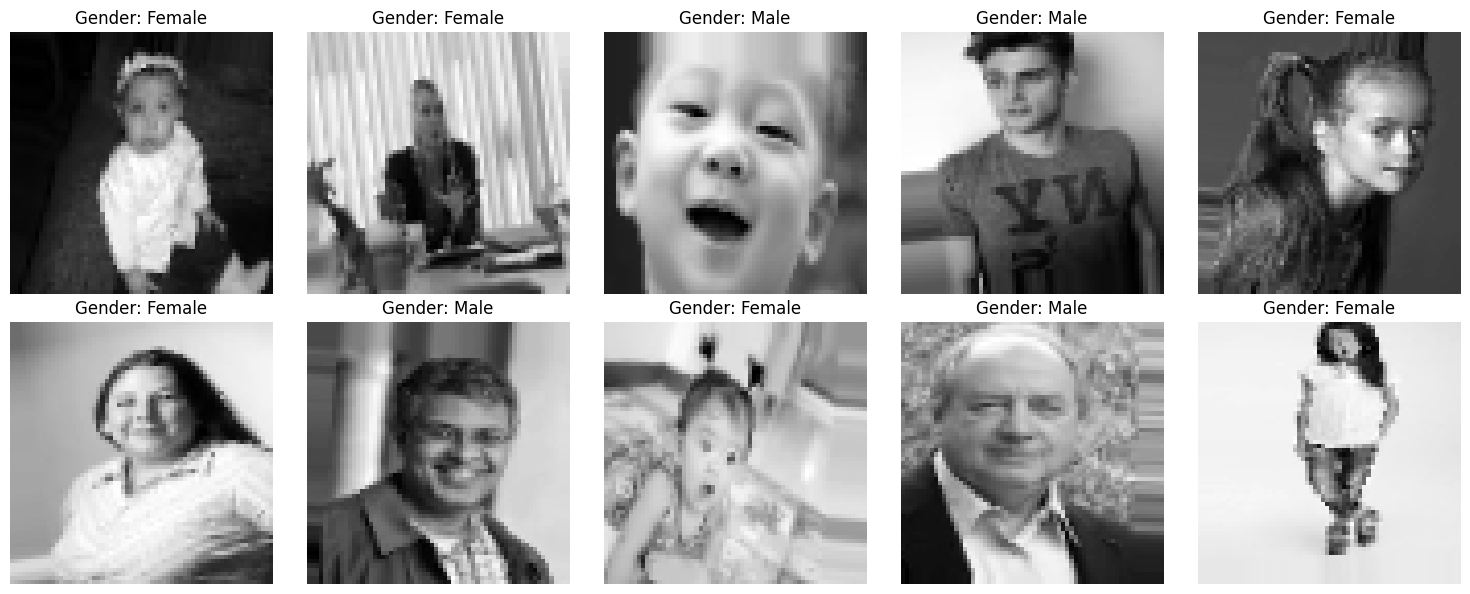


📈 Dataset summary:
📊 Age range: 1-110 years (99 unique values)
📊 Ethnicity categories: 5 unique values
📊 Gender distribution: {1: 5344, 0: 4363}
🎨 Distributions sẽ được tính toán ở cell tiếp theo cho visualization


In [49]:
# Tạo Data Generators để load ảnh trực tiếp
print("🔧 Đang tạo Data Generators...")

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Split data thành train/test
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['gender'])
print(f"📊 Train set: {len(train_data)} samples")
print(f"📊 Test set: {len(test_data)} samples")

# Reset index
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Custom data generator
class CustomImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size=32, target_size=(64, 64), shuffle=True, augment=False):
        super().__init__()
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(dataframe))
        self.on_epoch_end()
        
        # Data augmentation
        if augment:
            self.datagen = ImageDataGenerator(
                rotation_range=10,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True,
                rescale=1./255
            )
        else:
            self.datagen = ImageDataGenerator(rescale=1./255)
    
    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        return self._generate_batch(batch_indices)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def _generate_batch(self, batch_indices):
        batch_x = np.zeros((len(batch_indices),) + self.target_size + (1,))
        batch_y = np.zeros(len(batch_indices))
        
        for i, idx in enumerate(batch_indices):
            # Load image
            img_path = self.dataframe.iloc[idx]['filepath']
            img = load_img(img_path, target_size=self.target_size, color_mode='grayscale')
            img_array = img_to_array(img)
            
            # Apply augmentation if needed
            if self.augment:
                img_array = self.datagen.random_transform(img_array)
            
            # Normalize
            img_array = img_array / 255.0
            batch_x[i] = img_array
            batch_y[i] = self.dataframe.iloc[idx]['gender']
        
        return batch_x, batch_y

# Tạo generators
train_generator = CustomImageGenerator(
    train_data, 
    batch_size=32, 
    shuffle=True, 
    augment=True  # Data augmentation cho train
)

test_generator = CustomImageGenerator(
    test_data, 
    batch_size=32, 
    shuffle=False, 
    augment=False  # Không augment cho test
)

print("✅ Data Generators đã được tạo!")
print(f"📊 Train generator: {len(train_generator)} batches")
print(f"📊 Test generator: {len(test_generator)} batches")

# Hiển thị một batch mẫu
print("\n🖼️ Hiển thị sample images từ generator:")
sample_x, sample_y = train_generator[0]
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    if i < len(sample_x):
        row, col = i // 5, i % 5
        axes[row, col].imshow(sample_x[i].squeeze(), cmap='gray')
        axes[row, col].set_title(f"Gender: {'Male' if sample_y[i]==0 else 'Female'}")
        axes[row, col].axis('off')
    else:
        axes[row, col].axis('off')
plt.tight_layout()
plt.show()

print(f"\n📈 Dataset summary:")
print(f"📊 Age range: {data['age'].min()}-{data['age'].max()} years ({data['age'].nunique()} unique values)")
print(f"📊 Ethnicity categories: {data['ethnicity'].nunique()} unique values")
print(f"📊 Gender distribution: {data['gender'].value_counts().to_dict()}")
print("🎨 Distributions sẽ được tính toán ở cell tiếp theo cho visualization")


## Distributions <a id="03"></a>

In [35]:
# Chuẩn bị dữ liệu cho visualization
print("Chuẩn bị dữ liệu cho biểu đồ...")

age_dist = data['age'].value_counts().sort_index()
ethnicity_dist = data['ethnicity'].value_counts()
gender_dist = data['gender'].value_counts().rename(index={0:'Male',1:'Female'})

# Cấu hình plotting
USE_PLOTLY = False  # Set to True nếu muốn dùng plotly, False để dùng matplotlib

# Hàm vẽ biểu đồ với fallback cho matplotlib
def ditribution_plot(x, y, name):
    """Vẽ biểu đồ phân phối với plotly hoặc matplotlib"""
    if USE_PLOTLY:
        try:
            fig = go.Figure([go.Bar(x=x, y=y)])
            fig.update_layout(title_text=name)
            fig.show()
        except:
            # Fallback to matplotlib if plotly fails
            plt.figure(figsize=(12, 6))
            plt.bar(x, y)
            plt.title(name)
            plt.xlabel('Categories')
            plt.ylabel('Count')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
    else:
        plt.figure(figsize=(12, 6))
        plt.bar(x, y)
        plt.title(name)
        plt.xlabel('Categories')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Hàm vẽ biểu đồ training history
def line_plot(history_dict, title='Training History'):
    """Vẽ biểu đồ training history với plotly hoặc matplotlib"""
    if USE_PLOTLY:
        try:
            import plotly.express as px
            fig = px.line(
                history_dict, y=['loss', 'val_loss'],
                labels={'index': 'epoch', 'value': 'loss'},
                title=title)
            fig.show()
        except:
            # Fallback to matplotlib
            plt.figure(figsize=(12, 5))
            epochs = range(1, len(history_dict['loss']) + 1)
            plt.plot(epochs, history_dict['loss'], 'b-', label='Training Loss')
            plt.plot(epochs, history_dict['val_loss'], 'r-', label='Validation Loss')
            plt.title(title)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    else:
        plt.figure(figsize=(12, 5))
        epochs = range(1, len(history_dict['loss']) + 1)
        plt.plot(epochs, history_dict['loss'], 'b-', label='Training Loss')
        plt.plot(epochs, history_dict['val_loss'], 'r-', label='Validation Loss')
        plt.title(title)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Chuẩn bị dữ liệu cho biểu đồ...


### Age Distribtion <a id="3.1"></a>

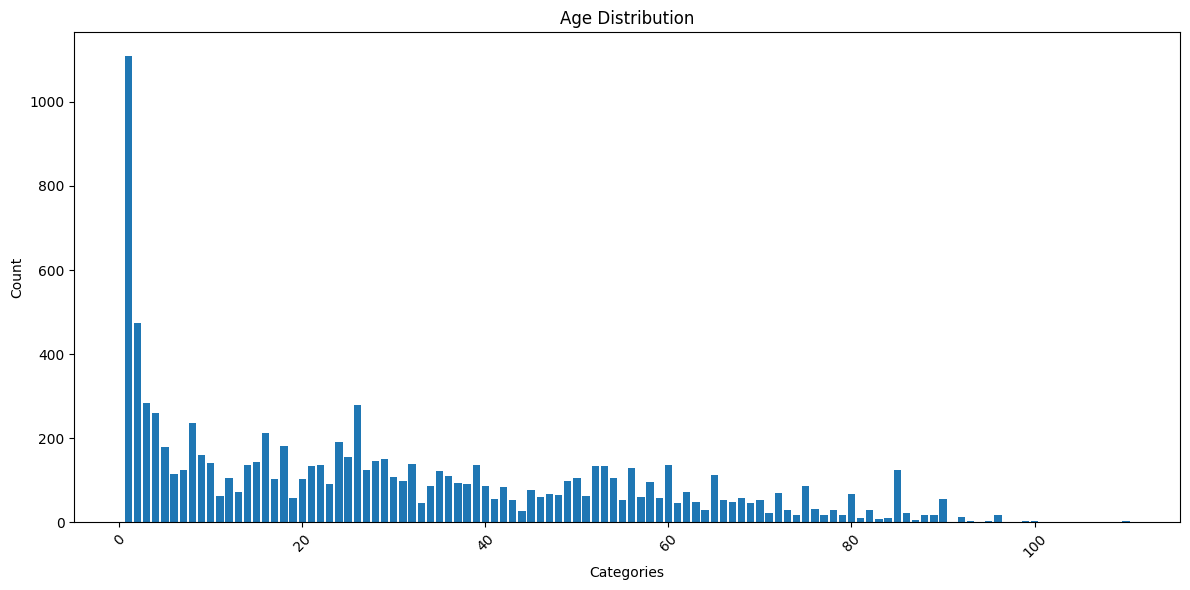

In [36]:
ditribution_plot(x=age_dist.index, y=age_dist.values, name='Age Distribution')

### Ethnicity Distribution <a id="3.2"></a>

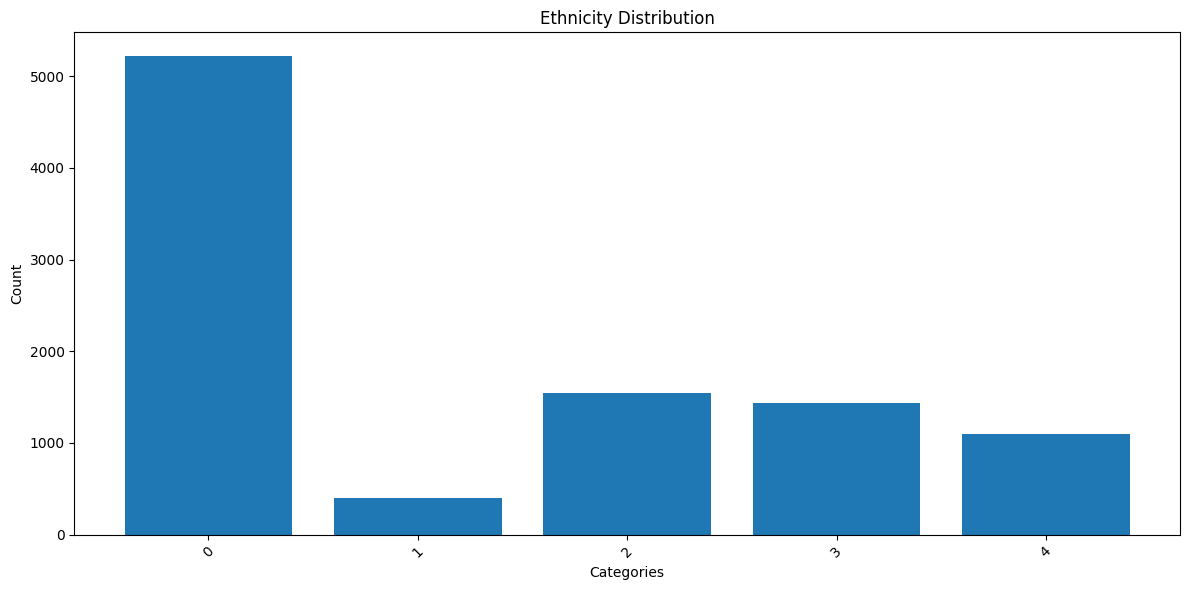

In [37]:
ditribution_plot(x=ethnicity_dist.index, y=ethnicity_dist.values, name='Ethnicity Distribution')

### Gender Distribution <a id="3.3"></a>

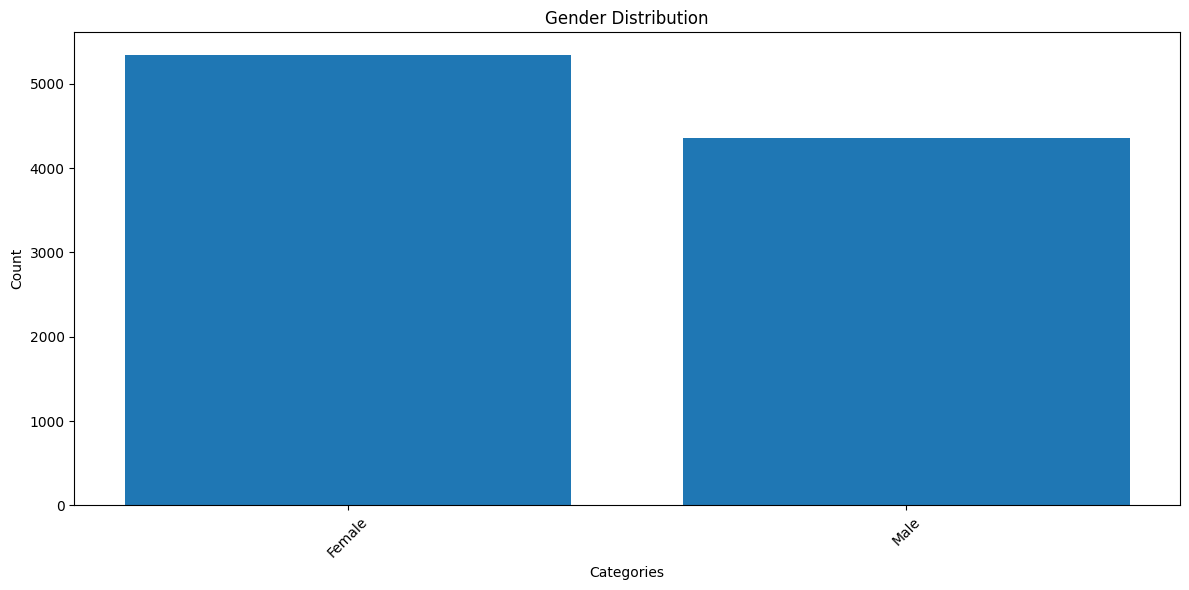

In [38]:
ditribution_plot(x=gender_dist.index, y=gender_dist.values, name='Gender Distribution')

 Hiển thị sample images từ dataset:


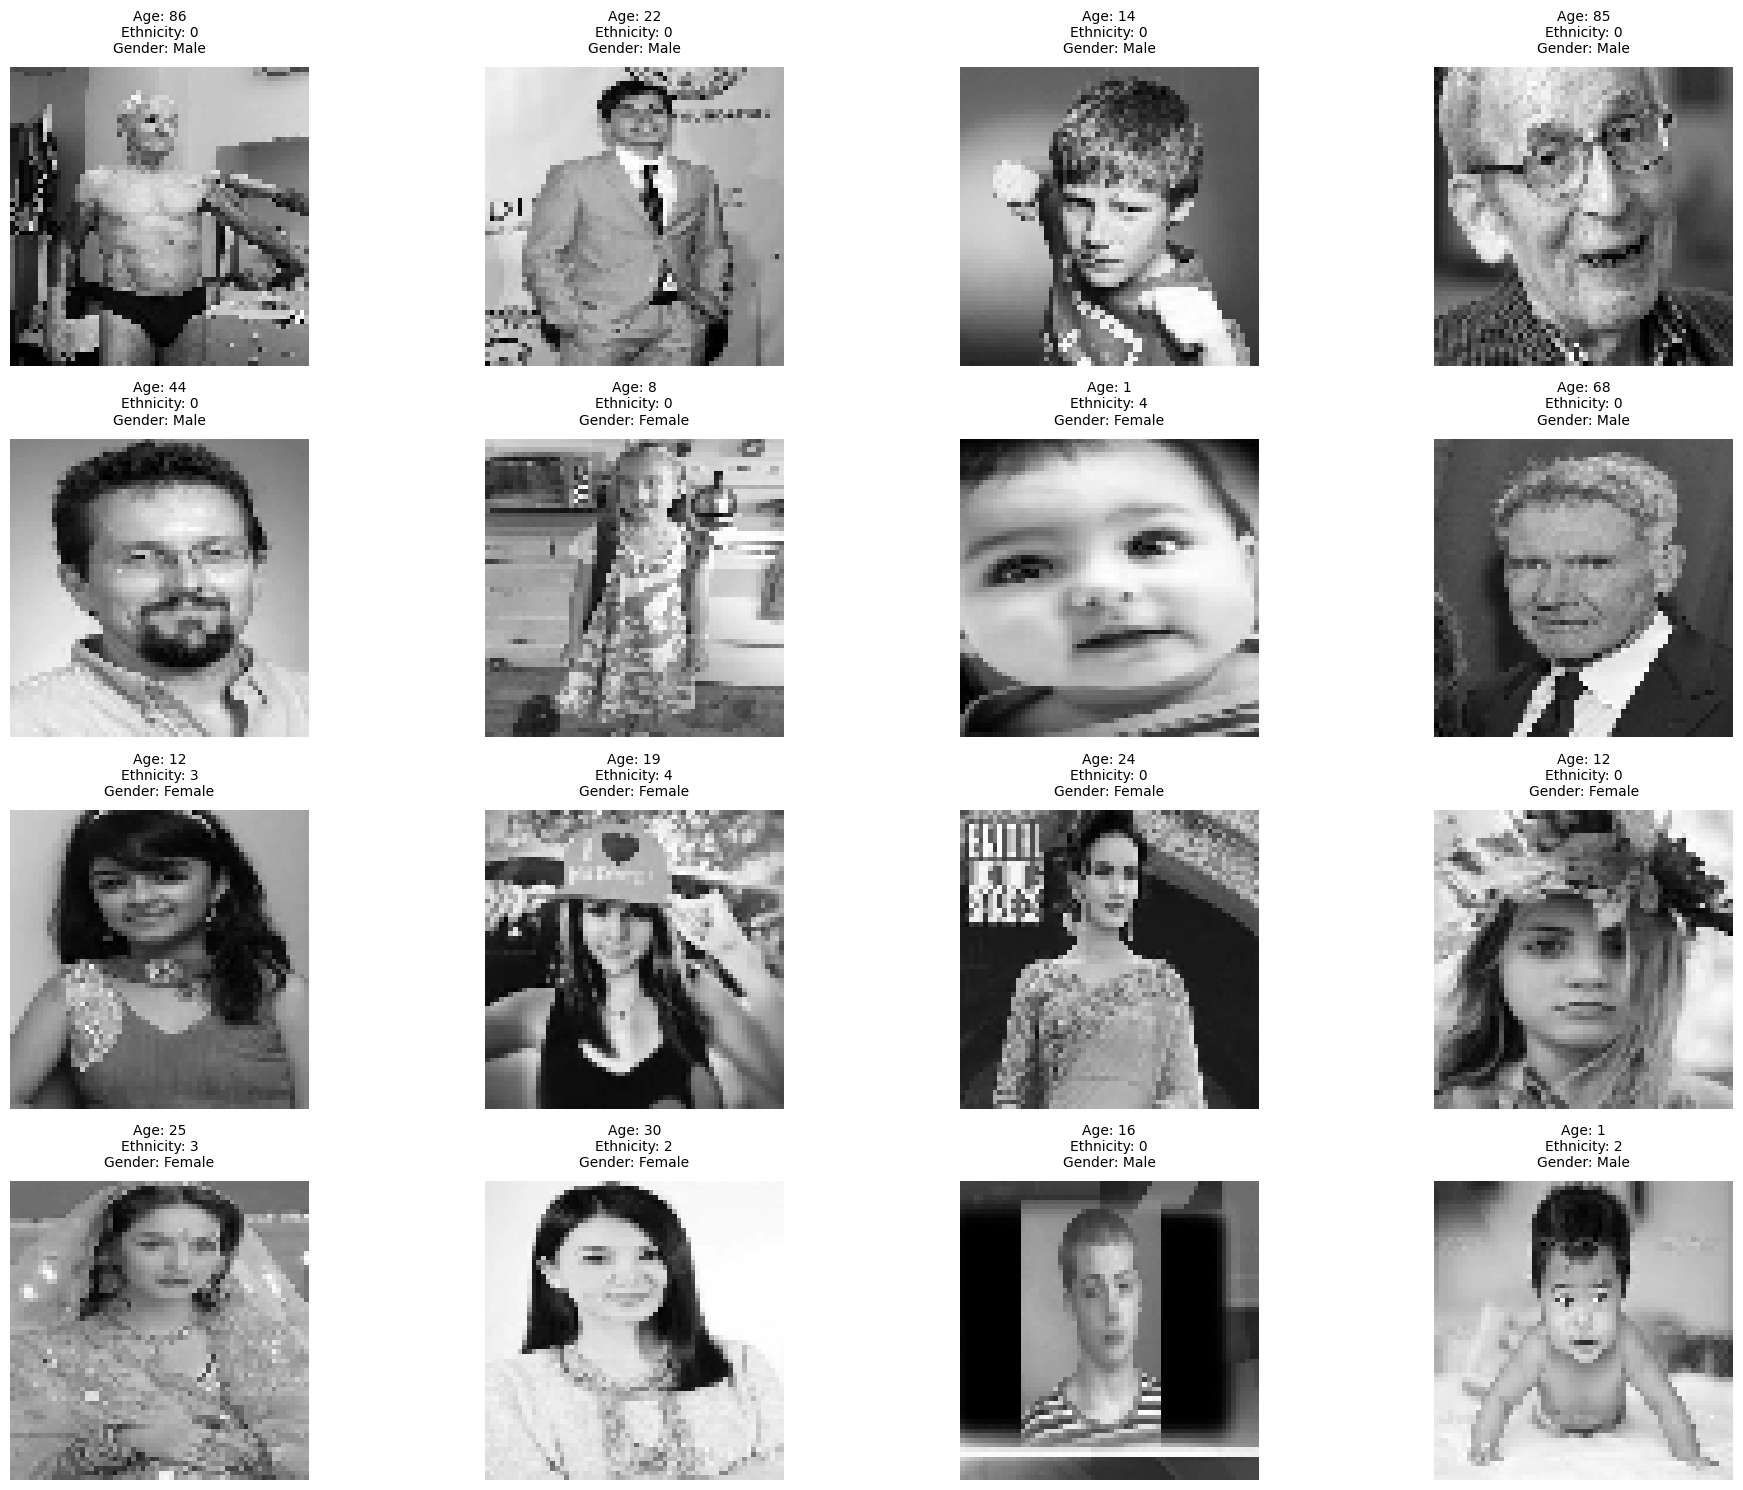

✅ Đã hiển thị 16 hình ảnh mẫu từ dataset
📊 Tổng số ảnh trong dataset: 9707

 Dataset Summary:
    Age range: 1-110 years
    Gender: {1: 5344, 0: 4363}
    Ethnicity: {0: 5217, 2: 1548, 3: 1437, 4: 1101, 1: 404}


In [39]:
# 🖼️ Hiển thị sample images từ dataset
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

print(" Hiển thị sample images từ dataset:")

sample_indices = np.random.choice(len(data), size=16, replace=False)

plt.figure(figsize=(20, 15))
for i, idx in enumerate(sample_indices):
    plt.subplot(4, 4, i + 1)
    
    # Lấy thông tin từ data
    row = data.iloc[idx]
    img_path = row['filepath']
    
    try:
        # Load và hiển thị ảnh
        img = load_img(img_path, target_size=(64, 64), color_mode='grayscale')
        img_array = img_to_array(img)
        
        plt.imshow(img_array.squeeze(), cmap='gray')
        plt.axis('off')
        
        # Hiển thị thông tin
        gender_text = 'Male' if row['gender'] == 0 else 'Female'
        title = f"Age: {row['age']}\nEthnicity: {row['ethnicity']}\nGender: {gender_text}"
        plt.title(title, fontsize=10, pad=10)
        
    except Exception as e:
        plt.text(0.5, 0.5, f"Error loading\n{row['filename']}", 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.axis('off')

plt.tight_layout()
plt.show()

print(f"✅ Đã hiển thị 16 hình ảnh mẫu từ dataset")
print(f"📊 Tổng số ảnh trong dataset: {len(data)}")

# Hiển thị distribution summary ngắn gọn
print(f"\n Dataset Summary:")
print(f"    Age range: {data['age'].min()}-{data['age'].max()} years")
print(f"    Gender: {data['gender'].value_counts().to_dict()}")
print(f"    Ethnicity: {data['ethnicity'].value_counts().to_dict()}")


 <a id="04"></a>

<h1 class="list-group-item active" style='background:purple; border:0'>
    <center>Model for Gender Prediction</center>
</h1>

### Split data into train/test <a id="4.1"></a>

### Build and train model <a id="4.2"></a>

In [40]:
# Xây dựng CNN model cho Gender Prediction

model = tf.keras.Sequential([
    L.Input(shape=(64, 64, 1)),  # Sửa input layer
    
    # First conv block
    L.Conv2D(32, (3, 3), activation='relu', padding='same'),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Dropout(0.25),
    
    # Second conv block  
    L.Conv2D(64, (3, 3), activation='relu', padding='same'),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Dropout(0.25),
    
    # Third conv block
    L.Conv2D(128, (3, 3), activation='relu', padding='same'),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Dropout(0.25),
    
    # Dense layers
    L.Flatten(),
    L.Dense(512, activation='relu'),
    L.Dropout(0.5),
    L.Dense(256, activation='relu'),
    L.Dropout(0.5),
    L.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model với optimizer tốt hơn
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


# Callbacks tốt hơn
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001,
    verbose=1
)

# Model checkpoint để lưu model tốt nhất
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_gender_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]

# Model summary
model.summary()

print(f"\n Model info:")
print(f"   - Input shape: (64, 64, 1)")
print(f"   - Total parameters: {model.count_params():,}")
print(f"   - Output: Binary classification (0=Male, 1=Female)")
print(f"   - Optimizer: Adam")
print(f"   - Callbacks: Early Stopping, LR Reduction, Model Checkpoint")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,419,969 (16.86 MB)

 Trainable params: 4,419,521 (16.86 MB)

 Non-trainable params: 448 (1.75 KB)


 Model info:
   - Input shape: (64, 64, 1)
   - Total parameters: 4,419,969
   - Output: Binary classification (0=Male, 1=Female)
   - Optimizer: Adam
   - Callbacks: Early Stopping, LR Reduction, Model Checkpoint


In [41]:
# Train model với Data Generators
print(f" Training batches: {len(train_generator)}")
print(f" Validation batches: {len(test_generator)}")

history = model.fit(
    train_generator,  # Sử dụng train generator
    epochs=30,  # Số epochs phù hợp
    validation_data=test_generator,  # Sử dụng test generator cho validation
    callbacks=callbacks,  # Sử dụng callbacks
    verbose=1
)
print(f"Epoch đã train: {len(history.history['loss'])}")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")


 Training batches: 243
 Validation batches: 61
Epoch 1/30
 20/243 ━━━━━━━━━━━━━━━━━━━━ 1:01 277ms/step - accuracy: 0.5347 - loss: 2.8753

KeyboardInterrupt: 

### Evaluate training history <a id="4.3"></a>

In [ ]:
line_plot(history.history, 'Gender Prediction - Training History')

In [ ]:
# Evaluate model với test generator
print("📊 Đang đánh giá model...")
loss, acc = model.evaluate(test_generator, verbose=0)
print('✅ Test loss: {:.4f}'.format(loss))
print('✅ Test Accuracy: {:.4f}'.format(acc))

# Thống kê chi tiết
print(f"\n📈 Kết quả chi tiết:")
print(f"🎯 Độ chính xác: {acc*100:.2f}%")
print(f"📉 Loss: {loss:.4f}")
print(f"📊 Số samples đánh giá: {len(test_data)}")
print(f"🎲 Random baseline: ~50% (binary classification)")

<a id="05"></a>

<h1 class="list-group-item active" style='background:purple; border:0'>
    <center>Model for Ethnicity Prediction</center>
</h1>

### Split data into train/test <a id="5.1"></a>

In [ ]:
y = data['ethnicity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

### Build and train model <a id="5.2"></a>

In [ ]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(64,64,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(5)
])

model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


## Stop training when validation accuracy reach 79%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.790):
            print("\nReached 79% val_accuracy so cancelling training!")
            self.model.stop_training = True

callback = myCallback()


model.summary()

In [ ]:
history = model.fit(
    X_train, y_train, epochs=16, validation_split=0.1, batch_size=64, callbacks=[callback]
)

### Evaluate training history <a id="5.3"></a>

In [ ]:
line_plot(history.history, 'Ethnicity Prediction - Training History')

In [ ]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

<a id="06"></a>

<h1 class="list-group-item active" style='background:orange; border:0'>
    <center>Model for Age prediction</center>
</h1>

### Split data into train/test <a id="6.1"></a>

In [ ]:
y = data['age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

### Build and train model <a id="6.2"></a>

In [ ]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(64,64,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(128, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(1, activation='relu')
])

sgd = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])


## Stop training when validation loss reach 110
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<110):
            print("\nReached 110 val_loss so cancelling training!")
            self.model.stop_training = True

callback = myCallback()


model.summary()

In [ ]:
history = model.fit(
    X_train, y_train, epochs=20, validation_split=0.1, batch_size=64, callbacks=[callback]
)

### Evaluate training history <a id="6.3"></a>

In [ ]:
line_plot(history.history, 'Age Prediction - Training History')

In [ ]:
mse, mae = model.evaluate(X_test,y_test,verbose=0)
print('Test Mean squared error: {}'.format(mse))
print('Test Mean absolute error: {}'.format(mae))

![Alt Text](https://www.kudos.com/assets/Blog/b5843aa89b/thankyou__FillWzcwMCw0NDBd.jpg)